In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gc
from tqdm import tqdm
from fpdf import FPDF
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
exams_sepsis = pd.read_csv("exams_all_sepsis.csv")
exams_sepsis

,subject_id,hadm_id,charttime,itemid,value,Sepsis,admittime,dischtime,discharge_location,offsettime,offsettime_disch
0,10000826,21086876,2146-12-18 21:20:00,51237.0,1.9,diagnostico,2146-12-18 17:39:00,2146-12-24 19:55:00,HOME,0 days 03:41:00,6 days 02:16:00
1,10000826,21086876,2146-12-19 05:15:00,51222.0,10.7,diagnostico,2146-12-18 17:39:00,2146-12-24 19:55:00,HOME,0 days 11:36:00,6 days 02:16:00
2,10000826,21086876,2146-12-19 05:15:00,51301.0,20.0,diagnostico,2146-12-18 17:39:00,2146-12-24 19:55:00,HOME,0 days 11:36:00,6 days 02:16:00
3,10000826,21086876,2146-12-19 05:15:00,50861.0,33,diagnostico,2146-12-18 17:39:00,2146-12-24 19:55:00,HOME,0 days 11:36:00,6 days 02:16:00
4,10000826,21086876,2146-12-19 05:15:00,50862.0,3.1,diagnostico,2146-12-18 17:39:00,2146-12-24 19:55:00,HOME,0 days 11:36:00,6 days 02:16:00
...,...,...,...,...,...,...,...,...,...,...,...
20692723,19999840,21033226,2164-09-17 13:34:00,50813.0,4.0,sepsis3,2164-09-10 13:47:00,2164-09-17 13:42:00,DIED,6 days 23:47:00,6 days 23:55:00
20692724,19999840,21033226,2164-09-17 13:34:00,50817.0,25,sepsis3,2164-09-10 13:47:00,2164-09-17 13:42:00,DIED,6 days 23:47:00,6 days 23:55:00
20692725,19999840,21033226,2164-09-17 13:39:00,50809.0,369,sepsis3,2164-09-10 13:47:00,2164-09-17 13:42:00,DIED,6 days 23:52:00,6 days 23:55:00
20692726,19999840,21033226,2164-09-17 13:39:00,50813.0,___,sepsis3,2164-09-10 13:47:00,2164-09-17 13:42:00,DIED,6 days 23:52:00,6 days 23:55:00


In [4]:
patients = exams_sepsis[['subject_id','hadm_id','offsettime_disch','discharge_location','Sepsis']].drop_duplicates()
patients['offsettime_disch'] = pd.to_timedelta(exams_sepsis['offsettime_disch'])
patients['hour_disch'] = (patients['offsettime_disch'].dt.total_seconds()//(60*60)).values.astype(int)

In [5]:
exams_sepsis['offsettime'] = pd.to_timedelta(exams_sepsis['offsettime'])
exams_sepsis['hour_exam'] = (exams_sepsis['offsettime'].dt.total_seconds()//(60*60)).values.astype(int)

/tmp/ipykernel_174523/3725535465.py:2: RuntimeWarning: invalid value encountered in cast
  exams_sepsis['hour_exam'] = (exams_sepsis['offsettime'].dt.total_seconds()//(60*60)).values.astype(int)


#### Análise das saídas dos pacientes

In [6]:
patients_alive = patients[patients['discharge_location'] != "DIED"]
patients_dead = patients[patients['discharge_location'] == "DIED"]

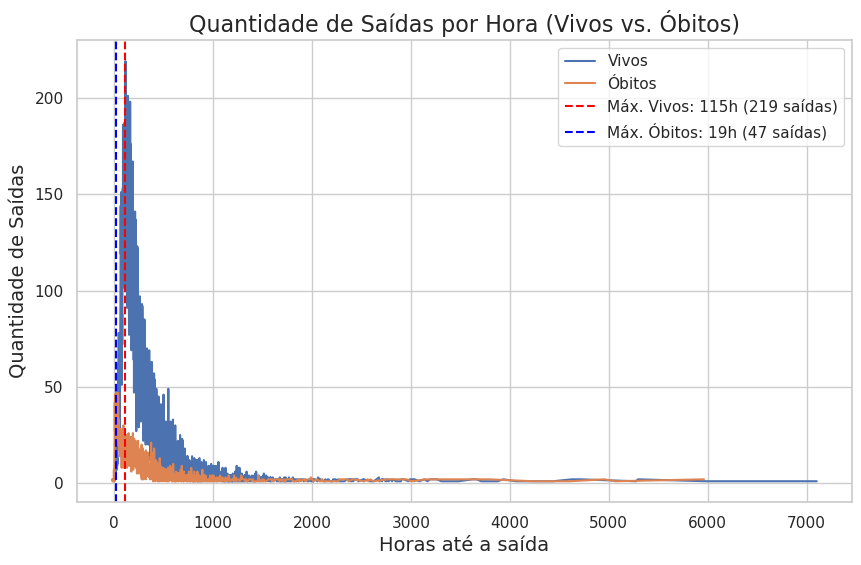

In [7]:
hourly_discharges_alive = patients_alive['hour_disch'].value_counts().sort_index()
hourly_discharges_dead = patients_dead['hour_disch'].value_counts().sort_index()

max_hour_alive = hourly_discharges_alive.idxmax()
max_count_alive = hourly_discharges_alive.max()

max_hour_dead = hourly_discharges_dead.idxmax()
max_count_dead = hourly_discharges_dead.max()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_discharges_alive.index, y=hourly_discharges_alive.values, label='Vivos')
sns.lineplot(x=hourly_discharges_dead.index, y=hourly_discharges_dead.values, label='Óbitos')

plt.axvline(x=max_hour_alive, color='red', linestyle='--', label=f'Máx. Vivos: {max_hour_alive}h ({max_count_alive} saídas)')
plt.axvline(x=max_hour_dead, color='blue', linestyle='--', label=f'Máx. Óbitos: {max_hour_dead}h ({max_count_dead} saídas)')

plt.title('Quantidade de Saídas por Hora (Vivos vs. Óbitos)', fontsize=16)
plt.xlabel('Horas até a saída', fontsize=14)
plt.ylabel('Quantidade de Saídas', fontsize=14)

plt.legend()
plt.show()


In [8]:
patients_dead

,subject_id,hadm_id,offsettime_disch,discharge_location,Sepsis,hour_disch
149,10001884,26184834,12 days 08:36:00,DIED,sepsis3,296
1094,10002155,20345487,0 days 05:22:00,DIED,sepsis3,5
7996,10003400,23559586,29 days 16:58:00,DIED,sepsis3,712
9298,10003400,23559586,29 days 16:58:00,DIED,diagnostico,712
13029,10004401,25777141,13 days 01:45:00,DIED,sepsis3,313
...,...,...,...,...,...,...
20674364,19992885,20352341,6 days 18:53:00,DIED,sepsis3,162
20677724,19995127,27369164,5 days 07:48:00,DIED,sepsis3,127
20690793,19998843,24842066,3 days 08:01:00,DIED,sepsis3,80
20691179,19999297,21439025,8 days 04:21:00,DIED,sepsis3,196


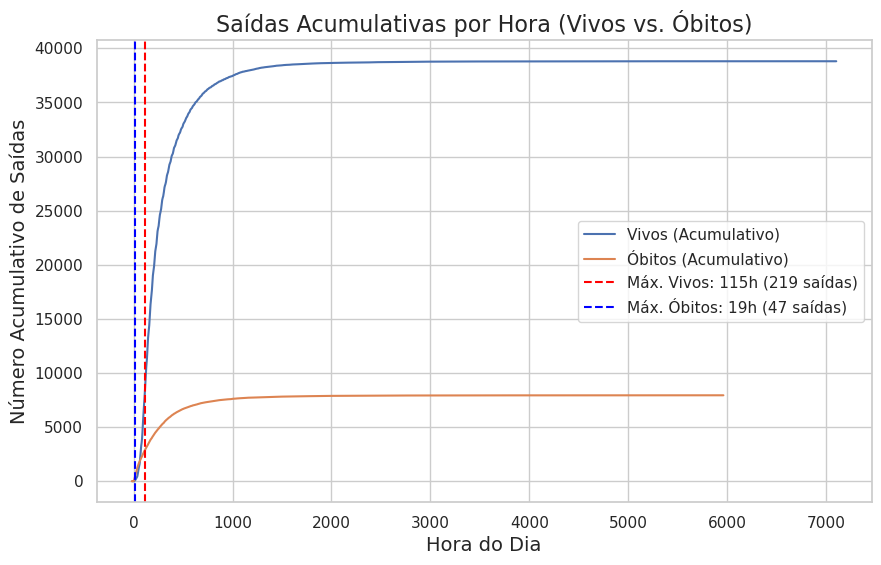

In [13]:
hourly_discharges_alive = patients_alive['hour_disch'].value_counts().sort_index()
cumulative_alive = hourly_discharges_alive.cumsum()

hourly_discharges_dead = patients_dead['hour_disch'].value_counts().sort_index()
cumulative_dead = hourly_discharges_dead.cumsum()

max_hour_alive = hourly_discharges_alive.idxmax()
max_hour_dead = hourly_discharges_dead.idxmax()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x=cumulative_alive.index, y=cumulative_alive.values, label='Vivos (Acumulativo)')
sns.lineplot(x=cumulative_dead.index, y=cumulative_dead.values, label='Óbitos (Acumulativo)')

plt.axvline(x=max_hour_alive, color='red', linestyle='--', label=f'Máx. Vivos: {max_hour_alive}h ({max_count_alive} saídas)')
plt.axvline(x=max_hour_dead, color='blue', linestyle='--', label=f'Máx. Óbitos: {max_hour_dead}h ({max_count_dead} saídas)')

plt.title('Saídas Acumulativas por Hora (Vivos vs. Óbitos)', fontsize=16)
plt.xlabel('Hora do Dia', fontsize=14)
plt.ylabel('Número Acumulativo de Saídas', fontsize=14)

plt.legend()
plt.show()


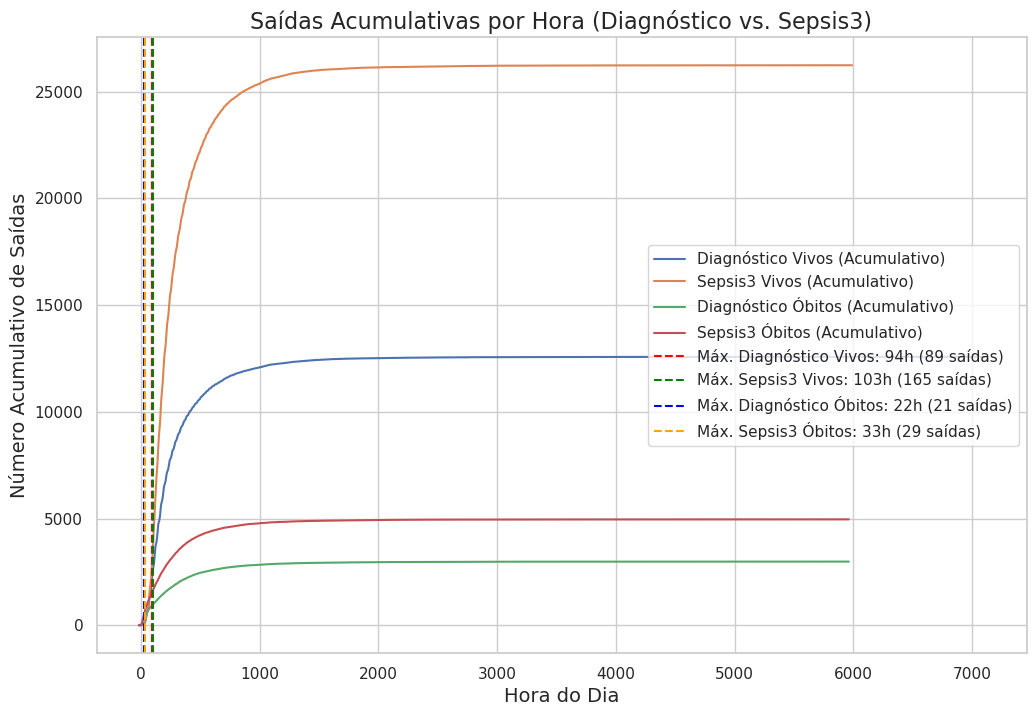

In [14]:
# Filtrando os dados para 'diagnostico' e 'sepsis3'
diagnostico_alive = patients_alive[patients_alive['Sepsis'] == 'diagnostico']
sepsis3_alive = patients_alive[patients_alive['Sepsis'] == 'sepsis3']

diagnostico_dead = patients_dead[patients_dead['Sepsis'] == 'diagnostico']
sepsis3_dead = patients_dead[patients_dead['Sepsis'] == 'sepsis3']

# Calculando as contagens e cumulativos
hourly_discharges_diagnostico_alive = diagnostico_alive['hour_disch'].value_counts().sort_index()
cumulative_diagnostico_alive = hourly_discharges_diagnostico_alive.cumsum()

hourly_discharges_sepsis3_alive = sepsis3_alive['hour_disch'].value_counts().sort_index()
cumulative_sepsis3_alive = hourly_discharges_sepsis3_alive.cumsum()

hourly_discharges_diagnostico_dead = diagnostico_dead['hour_disch'].value_counts().sort_index()
cumulative_diagnostico_dead = hourly_discharges_diagnostico_dead.cumsum()

hourly_discharges_sepsis3_dead = sepsis3_dead['hour_disch'].value_counts().sort_index()
cumulative_sepsis3_dead = hourly_discharges_sepsis3_dead.cumsum()

# Obtendo as horas máximas
max_hour_diagnostico_alive = hourly_discharges_diagnostico_alive.idxmax()
max_count_diagnostico_alive = hourly_discharges_diagnostico_alive.max()

max_hour_sepsis3_alive = hourly_discharges_sepsis3_alive.idxmax()
max_count_sepsis3_alive = hourly_discharges_sepsis3_alive.max()

max_hour_diagnostico_dead = hourly_discharges_diagnostico_dead.idxmax()
max_count_diagnostico_dead = hourly_discharges_diagnostico_dead.max()

max_hour_sepsis3_dead = hourly_discharges_sepsis3_dead.idxmax()
max_count_sepsis3_dead = hourly_discharges_sepsis3_dead.max()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))

# Plotando os gráficos
sns.lineplot(x=cumulative_diagnostico_alive.index, y=cumulative_diagnostico_alive.values, label='Diagnóstico Vivos (Acumulativo)')
sns.lineplot(x=cumulative_sepsis3_alive.index, y=cumulative_sepsis3_alive.values, label='Sepsis3 Vivos (Acumulativo)')

sns.lineplot(x=cumulative_diagnostico_dead.index, y=cumulative_diagnostico_dead.values, label='Diagnóstico Óbitos (Acumulativo)')
sns.lineplot(x=cumulative_sepsis3_dead.index, y=cumulative_sepsis3_dead.values, label='Sepsis3 Óbitos (Acumulativo)')

# Adicionando linhas verticais para os máximos
plt.axvline(x=max_hour_diagnostico_alive, color='red', linestyle='--', label=f'Máx. Diagnóstico Vivos: {max_hour_diagnostico_alive}h ({max_count_diagnostico_alive} saídas)')
plt.axvline(x=max_hour_sepsis3_alive, color='green', linestyle='--', label=f'Máx. Sepsis3 Vivos: {max_hour_sepsis3_alive}h ({max_count_sepsis3_alive} saídas)')

plt.axvline(x=max_hour_diagnostico_dead, color='blue', linestyle='--', label=f'Máx. Diagnóstico Óbitos: {max_hour_diagnostico_dead}h ({max_count_diagnostico_dead} saídas)')
plt.axvline(x=max_hour_sepsis3_dead, color='orange', linestyle='--', label=f'Máx. Sepsis3 Óbitos: {max_hour_sepsis3_dead}h ({max_count_sepsis3_dead} saídas)')

plt.title('Saídas Acumulativas por Hora (Diagnóstico vs. Sepsis3)', fontsize=16)
plt.xlabel('Hora do Dia', fontsize=14)
plt.ylabel('Número Acumulativo de Saídas', fontsize=14)

plt.legend()
plt.show()



#### Extração dos dados para modelo

In [9]:
itemid_map = {
    'Albumine': [52022, 53138, 50862, 53085],
    'Lactate': [50813, 52442, 53154],
    'Bicarbonate': [50813, 52442, 53154,50882],
    'Chloride': [50902, 52535],
    'Hemoglobin': [50811, 51222, 51640],
    'Sodium': [50983, 52623],
    'Glucose': [50809, 50931, 52569],
    'Troponin': [51002, 51003, 52642],
    'Platelets': [51240,51704,52159],
    'INR': [51237, 51675],
    'Creatinine': [50813, 52442, 53154,52024],
    'Bun': [51842,52647,51006],
    'Bilirubin': [50885, 53089],
    'AST': [50878, 53088],
    'ALT': [50861, 53084],
    'C_reactive': [50889],
    'ESR': [51288],
    'Bands': [51144],
    'WBC': [51301,53134,51300],
    'Oxygen_saturation': [50817],
    'Temperature': [223762,50825],
    'Systolic_pressure': [227242, 227243],
    'Respiratory_rate': [220210],
    'Heart_rate': [220045]
}

In [10]:
exams_24h = exams_sepsis[(exams_sepsis['hour_exam']>0) & (exams_sepsis['hour_exam']<=24)]
exams_24h['itemid'] = exams_24h['itemid'].astype(int)
exams_24h

/tmp/ipykernel_174523/2757645206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exams_24h['itemid'] = exams_24h['itemid'].astype(int)


,subject_id,hadm_id,charttime,itemid,value,Sepsis,admittime,dischtime,discharge_location,offsettime,offsettime_disch,hour_exam
0,10000826,21086876,2146-12-18 21:20:00,51237,1.9,diagnostico,2146-12-18 17:39:00,2146-12-24 19:55:00,HOME,0 days 03:41:00,6 days 02:16:00,3
1,10000826,21086876,2146-12-19 05:15:00,51222,10.7,diagnostico,2146-12-18 17:39:00,2146-12-24 19:55:00,HOME,0 days 11:36:00,6 days 02:16:00,11
2,10000826,21086876,2146-12-19 05:15:00,51301,20.0,diagnostico,2146-12-18 17:39:00,2146-12-24 19:55:00,HOME,0 days 11:36:00,6 days 02:16:00,11
3,10000826,21086876,2146-12-19 05:15:00,50861,33,diagnostico,2146-12-18 17:39:00,2146-12-24 19:55:00,HOME,0 days 11:36:00,6 days 02:16:00,11
4,10000826,21086876,2146-12-19 05:15:00,50862,3.1,diagnostico,2146-12-18 17:39:00,2146-12-24 19:55:00,HOME,0 days 11:36:00,6 days 02:16:00,11
...,...,...,...,...,...,...,...,...,...,...,...,...
20692616,19999840,21033226,2164-09-11 05:50:00,50931,90,sepsis3,2164-09-10 13:47:00,2164-09-17 13:42:00,DIED,0 days 16:03:00,6 days 23:55:00,16
20692617,19999840,21033226,2164-09-11 05:50:00,50983,138,sepsis3,2164-09-10 13:47:00,2164-09-17 13:42:00,DIED,0 days 16:03:00,6 days 23:55:00,16
20692618,19999840,21033226,2164-09-11 05:50:00,51006,10,sepsis3,2164-09-10 13:47:00,2164-09-17 13:42:00,DIED,0 days 16:03:00,6 days 23:55:00,16
20692619,19999840,21033226,2164-09-11 05:50:00,51222,14.6,sepsis3,2164-09-10 13:47:00,2164-09-17 13:42:00,DIED,0 days 16:03:00,6 days 23:55:00,16


In [16]:
exams_24h['exam_name'] = exams_24h['itemid'].apply(lambda x: next((name for name, ids in itemid_map.items() if x in ids), 'Unknown'))


/tmp/ipykernel_174523/3282492939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exams_24h['exam_name'] = exams_24h['itemid'].apply(lambda x: next((name for name, ids in itemid_map.items() if x in ids), 'Unknown'))


In [11]:
exams_24h['offsettime_disch'] = pd.to_timedelta(exams_24h['offsettime_disch'])
exams_24h['hour_disch'] = (exams_24h['offsettime_disch'].dt.total_seconds()//(60*60)).values.astype(int)

/tmp/ipykernel_174523/605478122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exams_24h['offsettime_disch'] = pd.to_timedelta(exams_24h['offsettime_disch'])
/tmp/ipykernel_174523/605478122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exams_24h['hour_disch'] = (exams_24h['offsettime_disch'].dt.total_seconds()//(60*60)).values.astype(int)


In [12]:
exams_24h = exams_24h[exams_24h['hour_disch']>24]

In [18]:
patients_24h = exams_24h
patients_24h.to_csv('patients_24h.csv')

In [19]:
exams_24h = exams_24h[['subject_id', 'hadm_id','exam_name','value','Sepsis']]
exams_24h.to_csv('exams_24h.csv')